In [16]:
import os
from PIL import Image, ImageDraw
import random
import tiledb
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# Utility functions

def create_jpeg_image(filepath):
    # pick a random RGB color
    w, h = 512, 512
    r, g, b = (random.randint(0, 255) for _ in range(3))
    img = Image.new("RGB", (w, h), color=(r, g, b))
    draw = ImageDraw.Draw(img)
    # choose white or black text depending on background brightness for readability
    brightness = (r * 299 + g * 587 + b * 114) / 1000
    text_color = (0, 0, 0) if brightness > 128 else (255, 255, 255)
    draw.text((10, 50), os.path.basename(filepath), fill=text_color)
    # add subtle noise/grain to the image
    noise_level = random.uniform(10, 80)    # controls noise pattern frequency
    noise_strength = random.uniform(0.04, 0.15)  # controls noise opacity
    noise = Image.effect_noise(img.size, noise_level).convert("RGB")
    img = Image.blend(img, noise, noise_strength)
    img.save(filepath, format="JPEG", quality=90)


In [ ]:
image_directory = "data/test_images"
image_paths = []
if not os.path.exists(image_directory):
    os.mkdir(image_directory)
for i in range (4):
    filepath = f"{image_directory}/test_image_{i+1}.jpg"
    create_jpeg_image(filepath)
    image_paths.append(filepath)

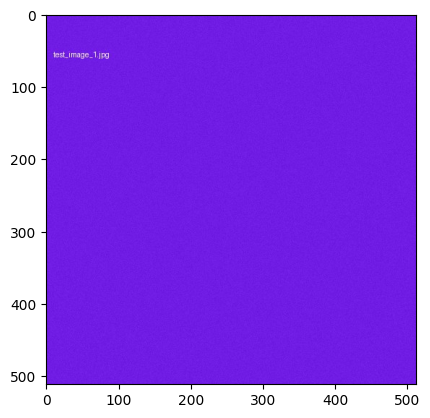

In [19]:
plt.imshow(Image.open(image_paths[0]))

In [ ]:
array_uri = "data/tiledb_blob_storage_array"
if os.path.exists(array_uri):
    shutil.rmtree(array_uri)

In [21]:
# Create one dimension
d1 = tiledb.Dim(name="d1", domain=(0, 3), tile=2, dtype=np.int32)

dom = tiledb.Domain(d1)

# This attribute will accept variable-length strings.
a = tiledb.Attr(name="a", dtype=np.bytes_)

# Create the array schema with `sparse=True`
sch = tiledb.ArraySchema(domain=dom, sparse=False, attrs=[a])

# Create the array on disk (it will initially be empty)
tiledb.Array.create(array_uri, sch)

In [22]:
# Read all images first, then write them in one open() (single commit)
d1_list = []
a_list = []

for i, fp in enumerate(image_paths):
    with open(fp, "rb") as f:
        img_bytes = f.read()
    d1_list.append(i)
    a_list.append(img_bytes)

d1_data = np.array(d1_list, dtype=np.int32)
# Use object dtype for variable-length bytes
a_data = np.array(a_list, dtype=object)

with tiledb.open(array_uri, 'w') as A:
    A[d1_data] = {"a": a_data}

In [86]:
%%timeit -o -n 1
with tiledb.open(array_uri) as A:
    data = A[0]["a"]



2.46 ms ± 746 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 2.46 ms ± 746 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)>

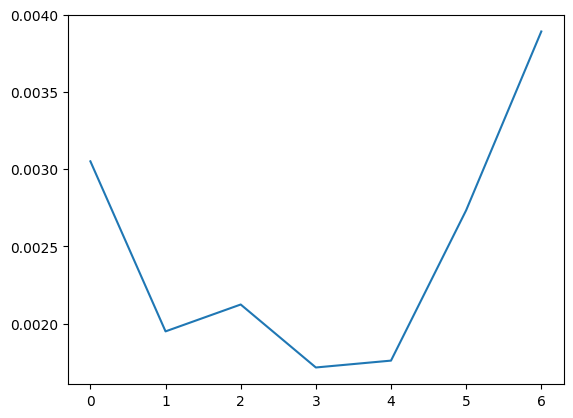

In [87]:
plt.plot([run for run in _.all_runs])

In [80]:
%%timeit -o -n 1
with open(image_paths[0], "rb") as f:
    img_bytes = f.read()

The slowest run took 38.60 times longer than the fastest. This could mean that an intermediate result is being cached.
54.6 µs ± 76.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 54.6 µs ± 76.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)>

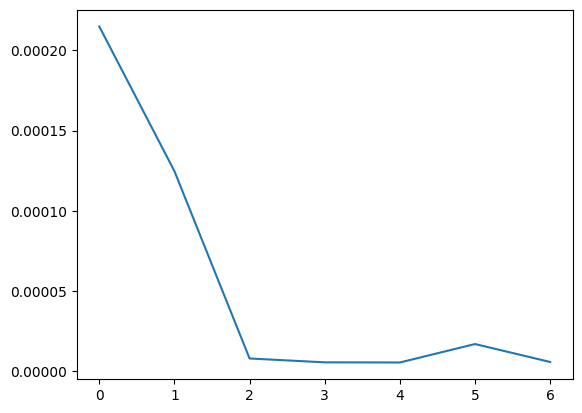

In [81]:
plt.plot([run for run in _.all_runs])

In [12]:
data

array([b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xdb\x00C\x01\x03\x04\x04\x05\x04\x05\t\x05\x05\t\x14\r\x0b\r\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\xff\xc0\x00\x11\x08\x02\x00\x02\x00\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x

In [13]:
for i, img_bytes in enumerate(data):
    print(f'Image {i} size: {len(img_bytes)} bytes')

Image 0 size: 24764 bytes
Image 1 size: 42128 bytes
Image 2 size: 18404 bytes
Image 3 size: 28881 bytes


This results in the following directory tree:
```bash
tiledb_blob_storage_array/
├── __commits
│   └── __1761231023619_1761231023619_622fccca9c9764f618c8251382530537_22.wrt
├── __fragment_meta
├── __fragments
│   └── __1761231023619_1761231023619_622fccca9c9764f618c8251382530537_22
│       ├── a0.tdb
│       ├── a0_var.tdb
│       ├── d0.tdb
│       └── __fragment_metadata.tdb
├── __labels
├── __meta
└── __schema
    ├── __1761231022144_1761231022144_00000002d95a6f8db114e47561e521a8
    └── __enumerations
```

Note that there is only one commit and thus only one fragment.

The storage footprint for the tiledb_blob_storage_array is 124 KB, vs the 48 KB for the 3 combined raw files on disk. This is dues to TileDB's overhead for managing the array structure and metadata. Suspect that this overhead will be minimal when storing batches of many (and larger) patches.

In [14]:
shutil.rmtree(array_uri)
shutil.rmtree(image_directory)